In [173]:
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2


def cal_distance(a, b, A, A_padding, mask, p_size):
    p = p_size // 2
    patch_a = A_padding[a[0]:a[0]+p_size, a[1]:a[1]+p_size, :]
    patch_b = A_padding[b[0]:b[0]+p_size, b[1]:b[1]+p_size, :]
    # patch_b = A[b[0]-p:b[0]+p+1, b[1]-p:b[1]+p+1, :]
    temp = patch_b - patch_a
    # this line excludes NaN from dist calculation, could be useful
    # to set masked pixels as NaN
    patch_mask = mask[b[0]-p:b[0]+p+1, b[1]-p:b[1]+p+1]
    if np.any(patch_mask > 0):  # Assuming mask value 1 indicates a masked pixel
        return 99999  # Return a high distance for patches with masked pixels

    num = np.sum(1 - np.int32(np.isnan(temp)))
    dist = np.sum(np.square(np.nan_to_num(temp))) / num
    return dist


def reconstruction(f, A):
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    out = np.zeros_like(A)
    for i in range(A_h):
        for j in range(A_w):
            out[i, j, :] = A[f[i, j][0], f[i, j][1], :]
    return out


def initialization(A, mask, p_size):
    print("Initializing random offsets...")
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    p = p_size // 2
    random_B_r = np.random.randint(p, A_h-p, [A_h, A_w])
    random_B_c = np.random.randint(p, A_w-p, [A_h, A_w])
    A_padding = np.ones([A_h+p*2, A_w+p*2, 3]) * np.nan
    A_padding[p:A_h+p, p:A_w+p, :] = A
    f = np.zeros([A_h, A_w], dtype=object)
    dist = np.zeros([A_h, A_w])
    for i in range(A_h):
        for j in range(A_w):
            a = np.array([i, j])
            # only randomize and calc distance for masked areas
            if (mask[i, j] > 0):
                b = np.array(
                    [random_B_r[i, j], random_B_c[i, j]], dtype=np.int32)
                f[i, j] = b
                dist[i, j] = cal_distance(a, b, A, A_padding, mask, p_size)
            else:
                # preserve unmasked areas
                f[i, j] = np.array([i, j])
                dist[i, j] = 0
    return f, dist, A_padding


def propagation(f, a, dist, A, A_padding, mask, p_size, is_odd):
    A_h = np.size(A_padding, 0) - p_size + 1
    A_w = np.size(A_padding, 1) - p_size + 1
    y = a[0]
    x = a[1]
    
    if is_odd:
        d_left = dist[y, max(x-1, 0)]
        d_up = dist[max(y-1, 0), x]

        d_current = dist[y, x]
        idx = np.argmin(np.array([d_current, d_left, d_up]))
        if idx == 1:
            f[y, x] = f[y, max(x - 1, 0)]
            dist[y, x] = cal_distance(a, f[y, x], A, A_padding, mask, p_size)
        if idx == 2:
            f[y, x] = f[max(y - 1, 0), x]
            dist[y, x] = cal_distance(a, f[y, x], A, A_padding, mask, p_size)
    else:
        d_right = dist[y, min(x + 1, A_w-1)]
        d_down = dist[min(y + 1, A_h-1), x]
        d_current = dist[y, x]
        idx = np.argmin(np.array([d_current, d_right, d_down]))
        if idx == 1:
            f[y, x] = f[y, min(x + 1, A_w-1)]
            dist[y, x] = cal_distance(a, f[y, x], A, A_padding, mask, p_size)
        if idx == 2:
            f[y, x] = f[min(y + 1, A_w-1), x]
            dist[y, x] = cal_distance(a, f[y, x], A, A_padding, mask, p_size)


def random_search(f, a, dist, A, A_padding, mask, p_size, alpha=0.5):
    y = a[0]
    x = a[1]
    A_h = np.size(A, 0)
    A_w = np.size(A, 1)
    p = p_size // 2
    i = 1
    search_h = A_h * alpha ** i
    search_w = A_w * alpha ** i
    b_x = f[y, x][0]
    b_y = f[y, x][1]
    while search_h > 1 and search_w > 1:
        search_min_r = max(b_x - search_h, p)
        search_max_r = min(b_x + search_h, A_h-p)
        if search_min_r >= search_max_r:
            return
        random_b_x = np.random.randint(search_min_r, search_max_r)
        search_min_c = max(b_y - search_w, p)
        search_max_c = min(b_y + search_w, A_w - p)
        if search_min_c >= search_max_c:
            return
        random_b_y = np.random.randint(search_min_c, search_max_c)
        i += 1
        search_h = A_h * alpha ** i
        search_w = A_w * alpha ** i
        b = np.array([random_b_x, random_b_y])
        d = cal_distance(a, b, A, A_padding, mask, p_size)
        if d < dist[y, x]:
            dist[y, x] = d
            f[y, x] = b


def NNS(img, img_sharp, mask, p_size, itr):
    print("Computing Nearest Neighbors...")
    A_h = np.size(img, 0)
    A_w = np.size(img, 1)
    f, dist, img_padding = initialization(img, mask, p_size)
    
    masked_indices = np.where(mask > 0)
    
    x_min = masked_indices[1].min()
    x_max = masked_indices[1].max()
    y_min = masked_indices[0].min()
    y_max = masked_indices[0].max()

    for itr in range(1, itr+1):
        if itr % 2 == 0:
            for i in tqdm(range(y_max, y_min - 1, -1)):
                for j in range(x_max, x_min - 1, -1):
                    if mask[i, j] > 0:
                        a = np.array([i, j])
                        propagation(f, a, dist, img, img_padding,
                                    mask, p_size, False)
                        random_search(f, a, dist, img,
                                      img_padding, mask, p_size)
        else:
            for i in tqdm(range(y_min, y_max + 1)):
                for j in range(x_min, x_max + 1):
                    if mask[i, j] > 0:
                        a = np.array([i, j])
                        propagation(f, a, dist, img, img_padding,
                                    mask, p_size, True)
                        random_search(f, a, dist, img,
                                      img_padding, mask, p_size)
        print("Completed iteration: %d"%(itr))
        plt.imshow(reconstruction(f, img_sharp))
        plt.show()
    return f


def visualize(f):
    """
    Get the NNF visualisation
    :return: The RGB Matrix of the NNF
    """

    img = np.zeros((f.shape[0], f.shape[1], 3), dtype=np.uint8)

    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            pos = f[i, j]
            img[i, j, 0] = int(255 * (pos[0] / f.shape[0]))
            img[i, j, 2] = int(255 * (pos[1] / f.shape[1]))

    return img


def gaussian_kernel(size, sigma=1):
    """Generate a Gaussian kernel."""
    x = np.arange(-size//2 + 1., size//2 + 1.)
    x, y = np.meshgrid(x, x)
    kernel = np.exp(-(x**2 + y**2) / (2. * sigma**2))
    cv2.getGaussianKernel
    return kernel / kernel.sum()


def reconstruct_avg_gaussian(f, img, patch_size=5, sigma=1):

    height, width = img.shape[:2]
    final_img = np.zeros_like(img)
    gaussian_sum = np.zeros_like(img, dtype=np.float32)

    # Generate Gaussian kernel
    g_kernel = gaussian_kernel(patch_size, sigma)[:, :, np.newaxis]

    # Iterate over each pixel in NNF
    print("Creating averaged reconstruction...")
    for y in tqdm(range(height)):
        # if (y % 100 == 0):
        #     plt.imshow(final_img)
        #     plt.show()
        for x in range(width):
            source_y, source_x = f[y, x]

            # Define source patch bounds
            src_top, src_bottom = max(
                source_y - patch_size // 2, 0), min(source_y + patch_size // 2 + 1, height)
            src_left, src_right = max(
                source_x - patch_size // 2, 0), min(source_x + patch_size // 2 + 1, width)

            tgt_top, tgt_bottom = max(
                y - patch_size // 2, 0), min(y + patch_size // 2 + 1, height)
            tgt_left, tgt_right = max(
                x - patch_size // 2, 0), min(x + patch_size // 2 + 1, width)

            overlap_height = min(src_bottom - src_top,
                                 tgt_bottom - tgt_top)
            overlap_width = min(src_right - src_left, tgt_right - tgt_left)

            if overlap_height > 0 and overlap_width > 0:
                # Extract patch and its corresponding kernel part
                patch = img[src_top:src_top + overlap_height,
                            src_left:src_left + overlap_width]
                kernel_part = g_kernel[:overlap_height, :overlap_width]

                # Element-wise multiply and add to final image and gaussian sum
                final_img[tgt_top:tgt_top + overlap_height,
                          tgt_left:tgt_left + overlap_width] += patch * kernel_part
                gaussian_sum[tgt_top:tgt_top + overlap_height,
                             tgt_left:tgt_left + overlap_width] += kernel_part
    # Normalize the final image
    final_img /= np.maximum(gaussian_sum, 1e-8)  # Prevent division by zero

    return final_img

def blur_unmasked(img, mask, kernel_size=5, noise_level = 0):
    noise = np.random.randn(*img.shape)
    blurred = cv2.GaussianBlur(img + noise_level * noise, (kernel_size, kernel_size), 0)
    # blurred_masked = np.where(mask[..., np.newaxis] == 0, blurred, img)
    # return blurred_masked
    return blurred

### Load images and masks here, configure patch size and iterations ###

(1000, 664, 3)


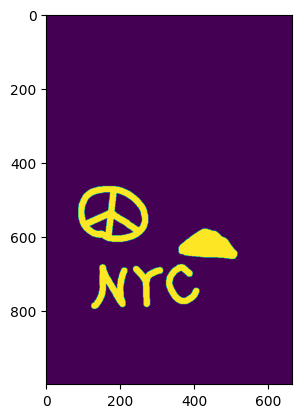

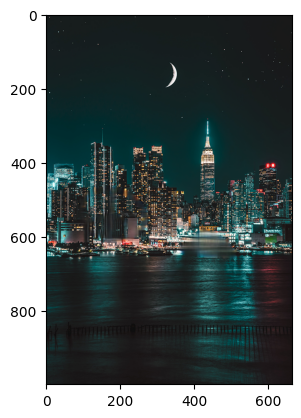

Computing Nearest Neighbors...
Initializing random offsets...


100%|██████████| 332/332 [00:22<00:00, 14.62it/s]


Completed iteration: 1


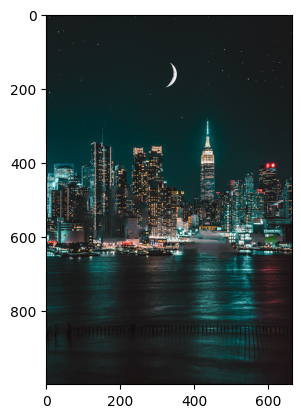

100%|██████████| 332/332 [00:22<00:00, 14.75it/s]


Completed iteration: 2


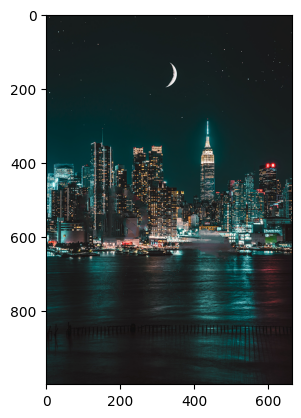

100%|██████████| 332/332 [00:22<00:00, 14.48it/s]


Completed iteration: 3


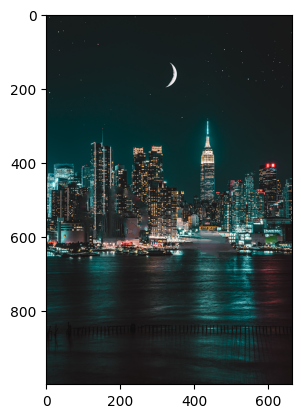

Creating averaged reconstruction...


100%|██████████| 1000/1000 [00:07<00:00, 125.04it/s]


In [174]:
# CONFIG
# patch size (larger is slower, but has more context)
p_size = 11

# number of iterations
itr = 3

file_name = "night"

# input image (from coarse gan output)
img = (plt.imread(f"examples/inpaint/results/gans/stage1/{file_name}.png")).astype(np.float32)
# threshold the mask
mask = (plt.imread(f"examples/inpaint/masks/{file_name}_mask.png") > 0).astype(np.float32)
# crop mask to match the image size (GAN output is sometimes cropped compared to original image/mask)
mask = mask[:img.shape[0], :img.shape[1]]
if len(mask.shape) > 2:
    mask = mask[:,:,1]

print(img.shape)

plt.imshow(mask)
plt.show()

# blur unmasked area by a certain amount
img_blurred = blur_unmasked(img, mask, kernel_size=1)
# img_blurred = (plt.imread("blurred+noise.png")).astype(np.float32)[:,:,:3]
plt.imshow(img_blurred)
plt.show()

f = NNS(img_blurred, img, mask, p_size, itr)
# plt.imsave("positions.png", visualize(f))

# outputs averaged patches
avg = reconstruct_avg_gaussian(f, img, patch_size=3, sigma=1)
plt.imsave(f"examples/inpaint/results_rpnn/{file_name}_1.png", avg)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


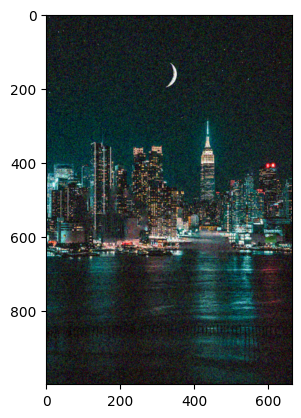

Computing Nearest Neighbors...
Initializing random offsets...


100%|██████████| 332/332 [00:24<00:00, 13.36it/s]


Completed iteration: 1


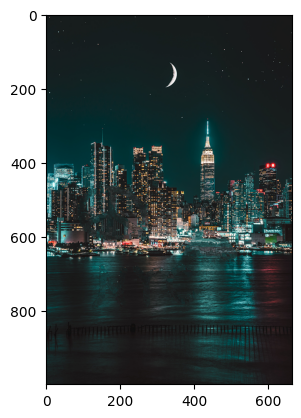

100%|██████████| 332/332 [00:24<00:00, 13.55it/s]


Completed iteration: 2


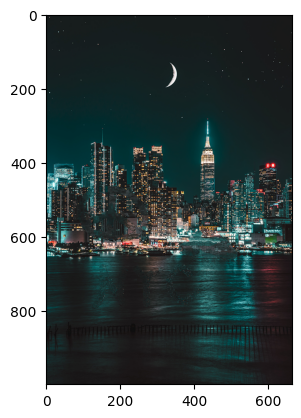

In [175]:
# Disturb the image with noise and blur, run a second pass to enhance details

img_blurred = blur_unmasked(avg, mask, kernel_size=3, noise_level=0.15)

plt.imshow(img_blurred)
plt.show()

f = NNS(img_blurred, img, mask, 25, 2)

Creating averaged reconstruction...


100%|██████████| 1000/1000 [00:10<00:00, 92.90it/s]


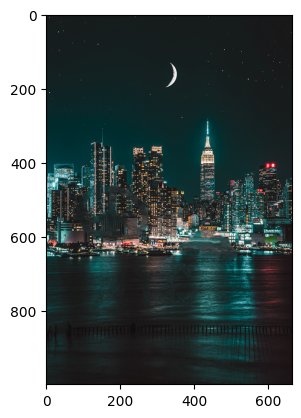

In [176]:
# outputs averaged patches
avg_second_pass = reconstruct_avg_gaussian(f, img, patch_size=9, sigma=1)
plt.imshow(avg_second_pass)
plt.show()
plt.imsave(f"examples/inpaint/results_rpnn/{file_name}_2.png", avg_second_pass)